In [142]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

In [143]:
df_list = []
filename_list = []
for filename in os.listdir("data/cleaned_data"):
    df = pd.read_csv(f"data/cleaned_data/{filename}")
    filename_list.append(filename)
    df_list.append(df)
print(filename_list)

['WS23_L3_T1_P_16.csv', 'WS23_L2_T2_P_3.csv', 'WS23_L2_T1_P_4.csv', 'WS23_L1_T1_P_17.csv', 'WS23_L2_T2_P_2.csv', 'WS23_L1_T1_P_8.csv', 'WS23_L1_T1_P_21.csv', 'WS23_L1_T1_P_16.csv', 'WS23_L3_T1_P_11.csv', 'WS23_L3_T1_P_25.csv', 'WS23_L1_T1_P_5.csv', 'WS23_L3_T1_P_9.csv', 'WS23_L2_T1_P_14.csv', 'WS23_L2_T1_P_12.csv', 'WS23_L2_T2_P_4.csv', 'WS23_L2_T1_P_9.csv', 'WS23_L2_T1_P_13.csv', 'WS23_L1_T1_P_23.csv', 'WS23_L1_T1_P_14.csv', 'WS23_L2_T1_P_6.csv', 'WS23_L2_T1_P_16.csv', 'WS23_L2_T2_P_0.csv', 'WS23_L2_T1_P_2.csv', 'WS23_L1_T1_P_7.csv', 'WS23_L1_T1_P_11.csv', 'WS23_L3_T1_P_17.csv', 'WS23_L3_T1_P_4.csv', 'WS23_L2_T1_P_5.csv', 'WS23_L1_T1_P_12.csv', 'WS23_L3_T1_P_29.csv', 'WS23_L2_T1_P_8.csv', 'WS23_L1_T1_P_6.csv', 'WS23_L3_T1_P_33.csv', 'WS23_L2_T1_P_10.csv', 'WS23_L3_T1_P_32.csv', 'WS23_L3_T1_P_6.csv', 'WS23_L1_T1_P_4.csv', 'WS23_L3_T1_P_15.csv', 'WS23_L1_T1_P_15.csv', 'WS23_L3_T1_P_1.csv', 'WS23_L1_T1_P_9.csv', 'WS23_L3_T1_P_0.csv', 'WS23_L1_T1_P_3.csv', 'WS23_L3_T1_P_13.csv', 'WS23_L2_

# Find Force-Drop

In [144]:
def find_force_drop_subranges(df: pd.DataFrame, percent_of_max_resistance: float):
    down_moves_subrange_list = []
    resistance_max = df['resistance'].max()
    min_drop_size = resistance_max * percent_of_max_resistance
    curr_peak_idx = 0
    curr_trough_idx = 0
    in_drop_subrange = 0 # bool

    for idx in range(1, len(df['resistance'])):
        curr_peak = df['resistance'].iloc[curr_peak_idx]
        curr_trough = df['resistance'].iloc[curr_trough_idx]
        curr_resistance = df['resistance'].iloc[idx]

        if curr_resistance >= curr_peak and in_drop_subrange:
            in_drop_subrange = 0
            down_moves_subrange_list.append((curr_peak_idx, curr_trough_idx))

        if curr_resistance >= curr_peak:
            curr_peak_idx = idx
            curr_trough_idx = idx
        elif curr_peak - curr_resistance >= min_drop_size and curr_resistance < curr_trough: 
            in_drop_subrange = 1
            curr_trough_idx = idx
    
    if in_drop_subrange: down_moves_subrange_list.append((curr_peak_idx, curr_trough_idx)) 
            
    return down_moves_subrange_list

def find_largest_force_drop(df: pd.DataFrame, subrange_list: List[Tuple]):
    curr_max_val = 0
    curr_max_level = 0
    for subrange_start, subrange_end in subrange_list:
        subrange_diff = df['resistance'].iloc[subrange_start] - df['resistance'].iloc[subrange_end]
        if subrange_diff > curr_max_val: 
            curr_max_val = subrange_diff
            curr_max_level = df['resistance'].iloc[subrange_start]
    return curr_max_val, curr_max_level

def plot(df_list: List[pd.DataFrame], plot_idx_range: List[int], title: str = 'Depth vs Resistance'):
    for idx in plot_idx_range:
        print(f"plot idx: {idx}")

        df = df_list[idx]
        percent = 0.1
        subranges = find_force_drop_subranges(df, percent)
        print(f"max_resistance: {df['resistance'].max()}")
        print(f"subranges: {[(float(df['resistance'].iloc[start]), float(df['resistance'].iloc[end])) for start, end in subranges]}")
        # print(f"")
        
        plt.figure(figsize=(5, 3))
        
        # Plot subrange start/end points
        for start_idx, end_idx in subranges:
            plt.plot(df['depth'].iloc[start_idx], df['resistance'].iloc[start_idx], marker='v', color='green')
            plt.plot(df['depth'].iloc[end_idx], df['resistance'].iloc[end_idx], marker='^', color='red')
        
        # Plot full depth vs resistance line
        plt.plot(df['depth'], df['resistance'],linestyle='-')
        plt.xlabel('Depth (m)')
        plt.ylabel('Resistance (N)')
        plt.title(f"{title} - Plot {idx}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# plot(df_list, plot_idx_range=range(len(df_list)))

# Find Curve Shape

In [145]:
def find_curve_shape(df):
    x = df['depth'].to_numpy()
    y = df['resistance'].to_numpy()
    # create evenly spaces points
    chord = np.linspace(df['resistance'].iloc[0], df['resistance'].iloc[-1], num=len(df['depth']))
    y_diff = y - chord # makes chord the x-axis, any y_points above chord are pos, below are neg
    return np.trapezoid(y=y_diff, x=x)

# Choose Features

In [ ]:
def extract_simple_features(df):
    res = df["resistance"]
    dep = df["depth"]

    return pd.DataFrame({
        "overall_slope": [res.max() / dep.max()],
        "max_depth": [dep.max()],
        "max_resistance": [res.max()],
        "num_peaks": len(find_force_drop_subranges(df,0.1)) / dep.max(),
        "largest_force_drop": find_largest_force_drop(df, find_force_drop_subranges(df, 0.05))[0],
        "curve_shape": find_curve_shape(df),
        "largest_force_drop_res_level": find_largest_force_drop(df, find_force_drop_subranges(df, 0.15))[1]
    })

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for i, df in enumerate(df_list):
    extracted_simple_features = extract_simple_features(df)
    representation_list.append(extracted_simple_features)
print(f"example: {representation_list[0]}")

example:    overall_slope  max_depth  max_resistance  num_peaks  largest_force_drop  \
0    2325.013184   0.014834       34.490185        0.0                   0   

   curve_shape  
0     0.033168  


# Correlation Matrix

In [147]:
representation_df = pd.concat(representation_list, axis=0, ignore_index=True)
corr_matrix = representation_df.corr()
print(corr_matrix)

                    overall_slope  max_depth  max_resistance  num_peaks  \
overall_slope            1.000000  -0.662021        0.591807  -0.321361   
max_depth               -0.662021   1.000000       -0.858433   0.567990   
max_resistance           0.591807  -0.858433        1.000000  -0.523997   
num_peaks               -0.321361   0.567990       -0.523997   1.000000   
largest_force_drop      -0.316209   0.387122       -0.260562   0.609810   
curve_shape              0.047448   0.060331        0.039995   0.036346   

                    largest_force_drop  curve_shape  
overall_slope                -0.316209     0.047448  
max_depth                     0.387122     0.060331  
max_resistance               -0.260562     0.039995  
num_peaks                     0.609810     0.036346  
largest_force_drop            1.000000    -0.096915  
curve_shape                  -0.096915     1.000000  


# Visualize Extracted Features Histograms

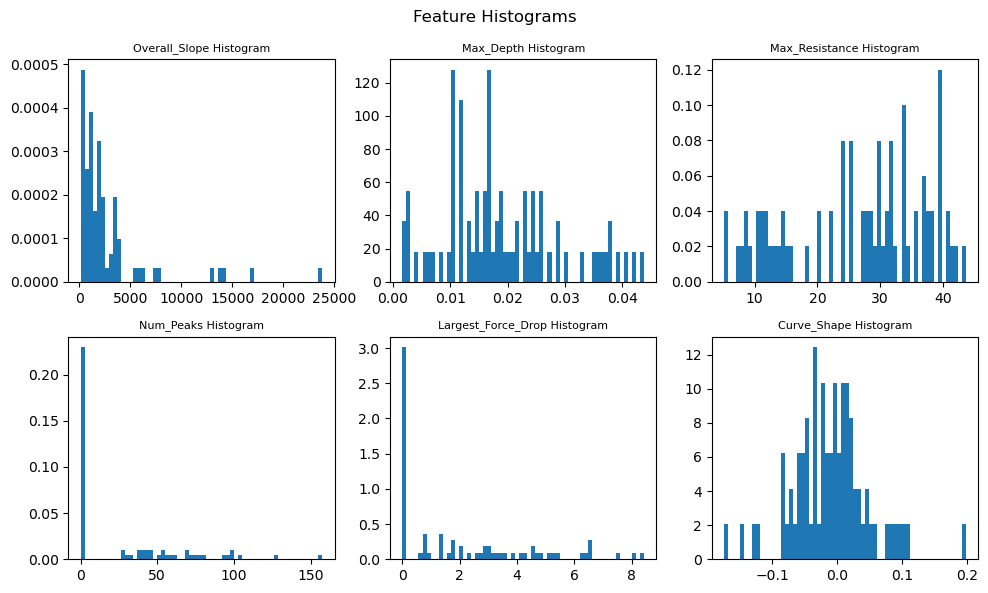

In [148]:
import math

def find_plot_dimensions(n):
    for i in range(int(math.sqrt(n)), 0, -1):
        if n % i == 0:
            # prime
            if i == 1 or n % i == 1: return find_plot_dimensions(n+1)
            else: return i, n // i

def plot_feature_dist(representation_df):
    # for col in representation_df.columns:
    x, y = find_plot_dimensions(len(representation_df.columns))
    fig, axs = plt.subplots(x,y,figsize=(10,6))
    fig.suptitle('Feature Histograms')
    for i, ax in enumerate(axs.flatten()):
        if i > len(representation_df.columns)-1: break
        col = representation_df.columns[i]
        ax.hist(representation_df[col], bins=60, density=True)
        ax.set_title(f"{col.title()} Histogram", fontsize=8)
    plt.tight_layout()
    plt.show()

plot_feature_dist(representation_df)

# Scale Features

   overall_slope  max_depth  max_resistance  num_peaks  largest_force_drop  \
0       0.388325  -0.406696        0.739042  -0.696539           -0.851451   
1       0.375944  -0.422131        0.660764  -0.696539            0.503095   
2      -0.379583   0.562019       -0.214852  -0.696539            0.133209   
3       2.157799  -1.626029        1.227728  -0.696539           -0.851451   
4      -0.574417   0.695309       -0.559701   1.372238            0.957454   

   curve_shape  
0     0.729832  
1    -0.659030  
2    -0.863595  
3     0.328081  
4     0.685768  


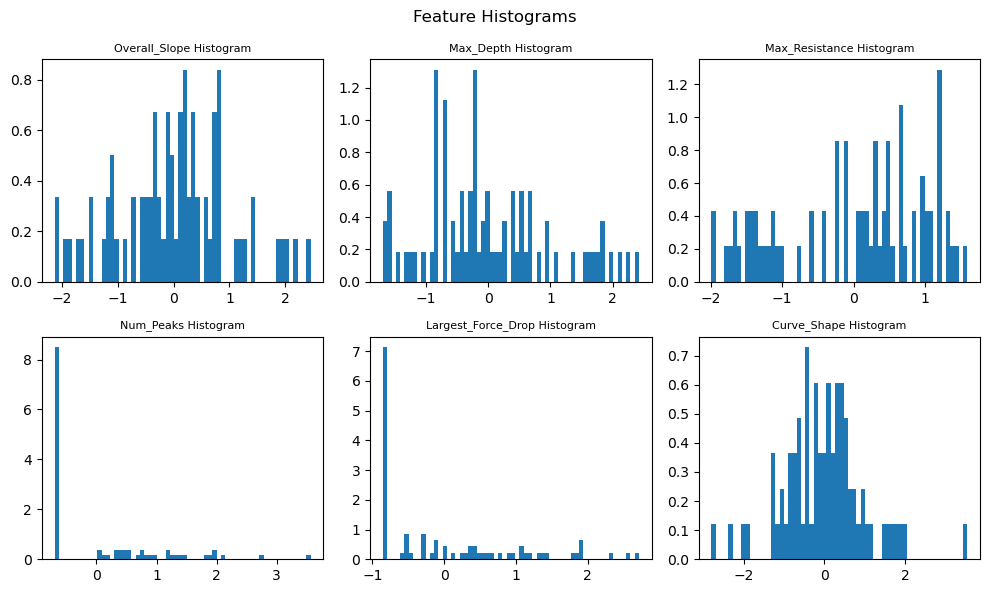

In [149]:
def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    if "overall_slope" in df.columns: df['overall_slope'] = np.log(df['overall_slope'])
    if "peaks" in df.columns: df['peaks'] = np.log(df['peaks'] + 1)
    if "peaks_value" in df.columns: df["peaks_value"] = np.log(df['peaks_value'])
    if 'force_drop' in df.columns: df['force_drop'] = np.log(df['force_drop'] + 1)
    if 'largest_force_drop_res_level' in df.columns: df['largest_force_drop_res_level'] = np.log(df['largest_force_drop_res_level'] + 1)
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)
print(scaled_representations[:5])
plot_feature_dist(scaled_representations)


In [150]:
corr_matrix = scaled_representations.corr()
print(corr_matrix)

                    overall_slope  max_depth  max_resistance  num_peaks  \
overall_slope            1.000000  -0.951302        0.930178  -0.566060   
max_depth               -0.951302   1.000000       -0.858433   0.567990   
max_resistance           0.930178  -0.858433        1.000000  -0.523997   
num_peaks               -0.566060   0.567990       -0.523997   1.000000   
largest_force_drop      -0.350411   0.387122       -0.260562   0.609810   
curve_shape              0.002262   0.060331        0.039995   0.036346   

                    largest_force_drop  curve_shape  
overall_slope                -0.350411     0.002262  
max_depth                     0.387122     0.060331  
max_resistance               -0.260562     0.039995  
num_peaks                     0.609810     0.036346  
largest_force_drop            1.000000    -0.096915  
curve_shape                  -0.096915     1.000000  


# Add Meta-Data

### Add FeiFei's y_labels

In [151]:
scaled_representations['filenames'] = filename_list

feifeis_filename_to_labels = {'WS23_L2_T1_P_3.csv': 'biotic crust', 'WS23_L2_T1_P_4.csv': 'biotic crust', 'WS23_L2_T1_P_6.csv': 'biotic crust', 
    'WS23_L2_T1_P_7.csv': 'biotic crust with surface nodules', 'WS23_L2_T1_P_8.csv': 'biotic crust with surface nodules', 
    'WS23_L2_T1_P_11.csv': 'strata', 'WS23_L2_T1_P_12.csv': 'strata', 'WS23_L2_T1_P_13.csv': 'crusty ripple', 
    'WS23_L2_T1_P_14.csv': 'strata', 'WS23_L2_T1_P_15.csv': 'strata', 'WS23_L2_T1_P_16.csv': 'abiotic crust on top of strata', 
    'WS23_L3_T1_P_1.csv': 'abiotic crust', 'WS23_L3_T1_P_3.csv': 'strong biotic crust', 'WS23_L3_T1_P_4.csv': 'abiotic crust', 
    'WS23_L3_T1_P_5.csv': 'abiotic crust', 'WS23_L3_T1_P_6.csv': 'abiotic crust', 'WS23_L3_T1_P_7.csv': 'abiotic crust', 
    'WS23_L3_T1_P_8.csv': 'abiotic crust', 'WS23_L3_T1_P_9.csv': 'strata', 'WS23_L3_T1_P_10.csv': 'crusty ripple', 
    'WS23_L3_T1_P_11.csv': 'crusty ripple', 'WS23_L3_T1_P_12.csv': 'crusty ripple', 'WS23_L3_T1_P_13.csv': 'crusty ripple', 
    'WS23_L3_T1_P_15.csv': 'crusty ripple', 'WS23_L3_T1_P_16.csv': 'crusty ripple', 'WS23_L3_T1_P_17.csv': 'crusty ripple', 
    'WS23_L3_T1_P_18.csv': 'crusty ripple', 'WS23_L3_T1_P_19.csv': 'abiotic crust with surface nodule', 
    'WS23_L3_T1_P_20.csv': 'crusty ripple', 'WS23_L3_T1_P_21.csv': 'crusty ripple', 'WS23_L3_T1_P_22.csv': 'strata', 
    'WS23_L3_T1_P_23.csv': 'strata with loose sand on top'}

scaled_representations['feifeis_ylabels'] = scaled_representations['filenames'].map(feifeis_filename_to_labels)

### Add Liam's y_labels 

In [152]:
liams_filenames_to_ylabels = {'WS23_L3_T1_P_16.csv': 0, 'WS23_L1_T1_P_8.csv': 0, 'WS23_L3_T1_P_11.csv': 0, 'WS23_L2_T1_P_14.csv': 0, 'WS23_L1_T1_P_23.csv': 0, 
                       'WS23_L2_T2_P_0.csv': 0, 'WS23_L1_T1_P_7.csv': 0, 'WS23_L1_T1_P_12.csv': 0, 'WS23_L3_T1_P_33.csv': 0, 'WS23_L2_T1_P_10.csv': 0, 
                       'WS23_L1_T1_P_4.csv': 0, 'WS23_L1_T1_P_3.csv': 0, 'WS23_L3_T1_P_13.csv': 0, 'WS23_L1_T1_P_22.csv': 0, 'WS23_L1_T1_P_10.csv': 0, 
                       'WS23_L3_T1_P_12.csv': 0, 'WS23_L1_T1_P_13.csv': 0, 'WS23_L3_T1_P_20.csv': 0, 'WS23_L3_T1_P_31.csv': 0, 'WS23_L2_T1_P_4.csv': 1, 
                       'WS23_L2_T2_P_2.csv': 1, 'WS23_L2_T2_P_4.csv': 1, 'WS23_L1_T1_P_15.csv': 1, 'WS23_L3_T1_P_3.csv': 1, 'WS23_L3_T1_P_18.csv': 1, 
                       'WS23_L1_T1_P_17.csv': 2, 'WS23_L3_T1_P_9.csv': 2, 'WS23_L2_T1_P_12.csv': 2, 'WS23_L1_T1_P_11.csv': 2, 'WS23_L3_T1_P_22.csv': 2, 
                       'WS23_L2_T1_P_15.csv': 2, 'WS23_L1_T1_P_20.csv': 2, 'WS23_L2_T1_P_11.csv': 2, 'WS23_L1_T1_P_18.csv': 2, 'WS23_L1_T1_P_21.csv': 3, 
                       'WS23_L1_T1_P_9.csv': 3, 'WS23_L3_T1_P_23.csv': 3, 'WS23_L1_T1_P_16.csv': 4, 'WS23_L1_T1_P_14.csv': 4, 'WS23_L3_T1_P_15.csv': 4, 
                       'WS23_L3_T1_P_25.csv': 5, 'WS23_L1_T1_P_5.csv': 5, 'WS23_L3_T1_P_27.csv': 5, 'WS23_L1_T1_P_1.csv': 5, 'WS23_L3_T1_P_26.csv': 5, 
                       'WS23_L2_T1_P_9.csv': 6, 'WS23_L3_T1_P_2.csv': 6, 'WS23_L2_T2_P_1.csv': 6, 'WS23_L3_T1_P_30.csv': 6, 'WS23_L2_T1_P_0.csv': 6, 
                       'WS23_L2_T1_P_13.csv': 7, 'WS23_L3_T1_P_17.csv': 7, 'WS23_L3_T1_P_21.csv': 7, 'WS23_L2_T1_P_6.csv': 8, 'WS23_L3_T1_P_29.csv': 8, 
                       'WS23_L2_T1_P_8.csv': 8, 'WS23_L3_T1_P_6.csv': 8, 'WS23_L3_T1_P_0.csv': 8, 'WS23_L2_T1_P_3.csv': 8, 'WS23_L3_T1_P_5.csv': 8, 
                       'WS23_L3_T1_P_24.csv': 8, 'WS23_L1_T1_P_0.csv': 8, 'WS23_L1_T1_P_19.csv': 8, 'WS23_L3_T1_P_19.csv': 8, 'WS23_L2_T1_P_17.csv': 8, 
                       'WS23_L1_T1_P_2.csv': 8, 'WS23_L2_T1_P_7.csv': 8, 'WS23_L2_T2_P_3.csv': 9, 'WS23_L2_T1_P_16.csv': 9, 'WS23_L3_T1_P_4.csv': 9, 
                       'WS23_L1_T1_P_6.csv': 9, 'WS23_L3_T1_P_8.csv': 9, 'WS23_L3_T1_P_7.csv': 9, 'WS23_L2_T1_P_2.csv': 10, 'WS23_L2_T1_P_5.csv': 10, 
                       'WS23_L3_T1_P_32.csv': 10, 'WS23_L3_T1_P_1.csv': 10, 'WS23_L2_T1_P_1.csv': 10, 'WS23_L3_T1_P_14.csv': 11, 'WS23_L3_T1_P_10.csv': 11}

scaled_representations['liams_ylabels'] = scaled_representations['filenames'].map(liams_filenames_to_ylabels)

### Add Marion's y_labels

In [153]:
marions_filenames_to_ylabels = {
    "WS23_L3_T1_P_0.csv": 'LS', "WS23_L3_T1_P_1.csv": 'ES-B', "WS23_L3_T1_P_2.csv": 'ES-B', "WS23_L3_T1_P_3.csv": 'ES-S',
    "WS23_L3_T1_P_4.csv": 'ES-B', "WS23_L3_T1_P_5.csv": 'ES-Bw', "WS23_L3_T1_P_6.csv": 'ES-Bw', "WS23_L3_T1_P_7.csv": 'ES-Bw',
    "WS23_L3_T1_P_8.csv": 'ES-Bw', "WS23_L3_T1_P_9.csv": 'F', "WS23_L3_T1_P_10.csv": 'ES-D', "WS23_L3_T1_P_11.csv": 'ES',
    "WS23_L3_T1_P_12.csv": 'F', "WS23_L3_T1_P_13.csv": 'F', "WS23_L3_T1_P_14.csv": 'ES-D', "WS23_L3_T1_P_15.csv": 'ES-D',
    "WS23_L3_T1_P_16.csv": 'ES-B', "WS23_L3_T1_P_17.csv": 'ES', "WS23_L3_T1_P_18.csv": 'ES-S', "WS23_L3_T1_P_19.csv": 'ES-S',
    "WS23_L3_T1_P_20.csv": 'LS/F', "WS23_L3_T1_P_21.csv": 'ES', "WS23_L3_T1_P_22.csv": 'ES', "WS23_L3_T1_P_23.csv": 'LS'
}

scaled_representations['marions_ylabels'] = scaled_representations['filenames'].map(marions_filenames_to_ylabels)

### Add feet from dune

In [154]:
filenames_list = ['WS23_L1_T1_P_0.csv', 'WS23_L1_T1_P_1.csv', 'WS23_L1_T1_P_2.csv', 'WS23_L1_T1_P_3.csv', 'WS23_L1_T1_P_4.csv', 'WS23_L1_T1_P_5.csv', 'WS23_L1_T1_P_6.csv', 'WS23_L1_T1_P_7.csv', 'WS23_L1_T1_P_8.csv', 'WS23_L1_T1_P_9.csv', 'WS23_L1_T1_P_10.csv', 'WS23_L1_T1_P_11.csv', 'WS23_L1_T1_P_12.csv', 'WS23_L1_T1_P_13.csv', 'WS23_L1_T1_P_14.csv', 'WS23_L1_T1_P_15.csv', 'WS23_L1_T1_P_16.csv', 'WS23_L1_T1_P_17.csv', 'WS23_L1_T1_P_18.csv', 'WS23_L1_T1_P_19.csv', 'WS23_L2_T1_P_0.csv', 'WS23_L2_T1_P_1.csv', 'WS23_L2_T1_P_2.csv', 'WS23_L2_T1_P_3.csv', 'WS23_L2_T1_P_4.csv', 'WS23_L2_T1_P_5.csv', 'WS23_L2_T1_P_6.csv', 'WS23_L2_T1_P_7.csv', 'WS23_L2_T1_P_8.csv', 'WS23_L2_T1_P_9.csv', 'WS23_L2_T1_P_10.csv', 'WS23_L2_T1_P_11.csv', 'WS23_L2_T1_P_12.csv', 'WS23_L2_T1_P_13.csv', 'WS23_L2_T1_P_14.csv', 'WS23_L2_T1_P_15.csv', 'WS23_L2_T1_P_16.csv', 'WS23_L2_T1_P_17.csv', 'WS23_L2_T2_P_0.csv', 'WS23_L2_T2_P_1.csv', 'WS23_L2_T2_P_2.csv', 'WS23_L2_T2_P_3.csv', 'WS23_L2_T2_P_4.csv', 'WS23_L3_T1_P_0.csv', 'WS23_L3_T1_P_1.csv', 'WS23_L3_T1_P_2.csv', 'WS23_L3_T1_P_3.csv', 'WS23_L3_T1_P_4.csv', 'WS23_L3_T1_P_5.csv', 'WS23_L3_T1_P_6.csv', 'WS23_L3_T1_P_7.csv', 'WS23_L3_T1_P_8.csv', 'WS23_L3_T1_P_9.csv', 'WS23_L3_T1_P_10.csv', 'WS23_L3_T1_P_11.csv', 'WS23_L3_T1_P_12.csv', 'WS23_L3_T1_P_13.csv', 'WS23_L3_T1_P_14.csv', 'WS23_L3_T1_P_15.csv', 'WS23_L3_T1_P_16.csv', 'WS23_L3_T1_P_17.csv', 'WS23_L3_T1_P_18.csv', 'WS23_L3_T1_P_19.csv', 'WS23_L3_T1_P_20.csv', 'WS23_L3_T1_P_21.csv', 'WS23_L3_T1_P_22.csv', 'WS23_L3_T1_P_23.csv']
distances_list = [0, 3, 5.5, 10.5, 12, 14, 38, 41.5, 44, 47, 51, 90, 93, 96, 102, 107, 151, 152, 153, 170, 3.25, 0, 6, 13, 16, 19, 24, 64, 67, 72, 75, 87, 88, 88, 91, 95, 112, 116, 0, 4, 11, 20, 27, 0, 10, 16, 19, 40, 49, 98, 160, 161, 187, 188, 229, 253, 254, 255, 308, 317, 318, 353, 357, 363, 369, 384, 389]

filenames_to_distances = dict(zip(filenames_list, distances_list))
scaled_representations['distances'] = scaled_representations['filenames'].map(filenames_to_distances)

# Save representation

In [155]:
scaled_representations.to_csv(f"data/features.csv", index=False)
print(scaled_representations)

    overall_slope  max_depth  max_resistance  num_peaks  largest_force_drop  \
0        0.388325  -0.406696        0.739042  -0.696539           -0.851451   
1        0.375944  -0.422131        0.660764  -0.696539            0.503095   
2       -0.379583   0.562019       -0.214852  -0.696539            0.133209   
3        2.157799  -1.626029        1.227728  -0.696539           -0.851451   
4       -0.574417   0.695309       -0.559701   1.372238            0.957454   
..            ...        ...             ...        ...                 ...   
73       0.806681  -0.864165        1.045351  -0.696539           -0.851451   
74      -0.061308   0.122906        0.171270   1.971547            1.093174   
75       2.453609  -1.691588        1.199750  -0.696539           -0.851451   
76      -0.374962  -0.666713       -1.357503  -0.696539           -0.570790   
77      -1.858353   2.253277       -1.746746   1.871178           -0.012681   

    curve_shape            filenames               